## Prediction Problem Interim Report {-}

In [2]:
# | echo: false
import pandas as pd
import numpy as np
import patsy

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Train X and y
train_X = pd.read_csv('train_X.csv')
train_y = pd.read_csv('train_y.csv')
train = train_X.merge(train_y, on='ID').drop(columns=['ID'])

# Test X
test_X = pd.read_csv('public_private_X.csv')

## 1) Exploratory Data Analysis (EDA)

The first thing that I noticed about this dataset was that it contained datetime columns, which I immediately extracted the day and month attributes from. I did not extract the year attribute, as all the observations only have one unique year - 2009. I also did not extract the weekday columns as those already exist as separate variables in `DUE_DATE_WEEKDAY` and `ORDER_DAY_OF_WEEK`. 

I started my exploratory data analysis by examining each numerical predictor's Pearson correlation coefficient to the response, `ON_TIME_AND_COMPLETE`. Below is the correlation table. This informed me as to which predictors may be more useful than others. 

In [4]:
# correlation coefficients assicated with ON_TIME_AND_COMPLETE
train.select_dtypes(exclude='object').corrwith(train.ON_TIME_AND_COMPLETE).sort_values(ascending=False)[1:]

PRODUCT_CLASSIFICATION                   0.266281
COMPANY_VENDOR_NUMBER                    0.238684
PURCHASE_FROM_VENDOR                     0.199145
GIVEN_TIME_TO_LEAD_TIME_RATIO            0.101843
AVERAGE_DAILY_DEMAND_CASES               0.091601
SHIP_FROM_VENDOR                         0.068787
DUE_DATE_WEEKDAY                         0.015874
PRODUCT_NUMBER                           0.011300
AVERAGE_ORDER_CYCLE_CASES                0.010446
ORDER_QUANTITY_DEVIATION                 0.006848
PURCHASE_ORDER_TYPE                     -0.010708
PRODUCT_MARKET                          -0.018960
DIVISION_NUMBER                         -0.025631
ORDER_DAY_OF_WEEK                       -0.028731
LEAD_TIME_TO_DISTANCE_RATIO             -0.060109
AVERAGE_VENDOR_ORDER_CYCLE_DAYS         -0.076440
AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET   -0.095015
AVERAGE_ORDER_CYCLE_DAYS                -0.113561
DISTANCE_IN_MILES                       -0.118058
TRANSIT_LEAD_TIME                       -0.128883


This correlation table was not enough to determine which variables needed to be dropped, transformed, combined, etc. I proceeded by creating a histogram for each predictor (separated by the response value) as well as a log-odds plot for each predictor. I estimated the log odds by binning and grouping the data, taking the mean value of the response column in each group in order to calculate log-odds, so as to avoid division by zero errors. Below is the code that produces the visualizations.

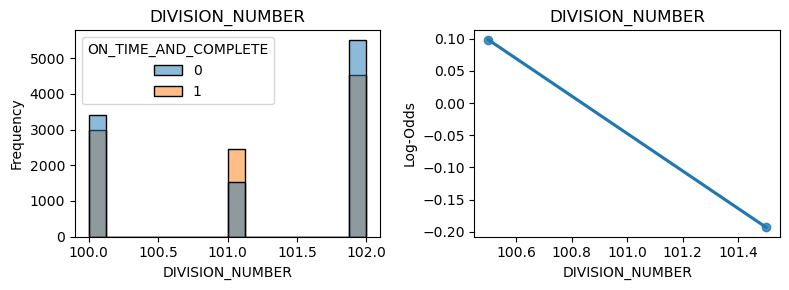

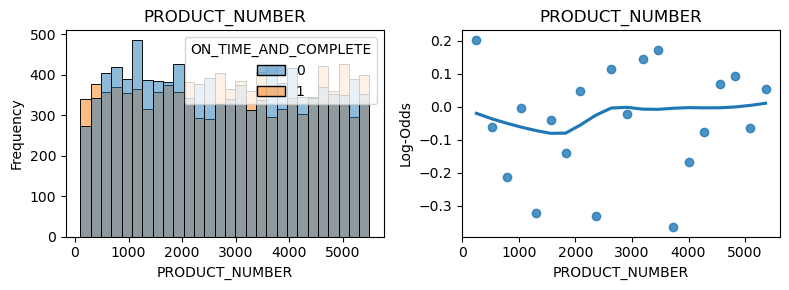

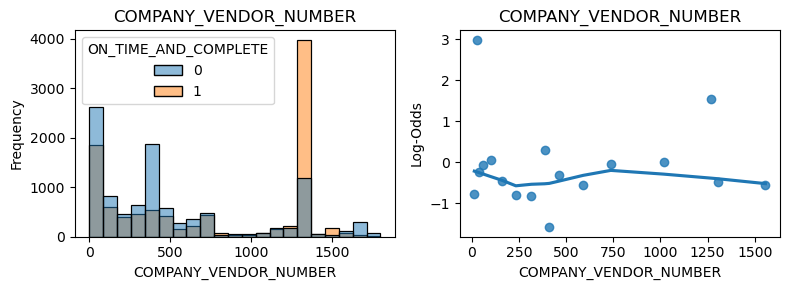

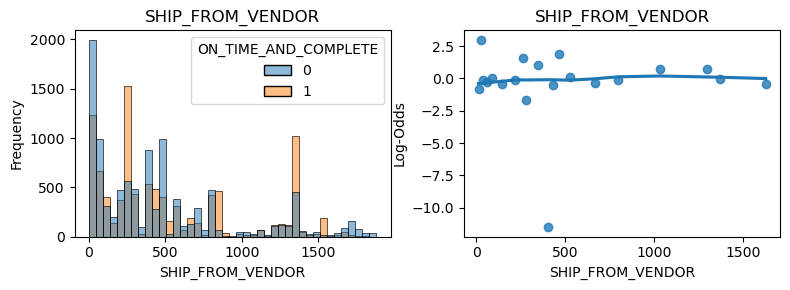

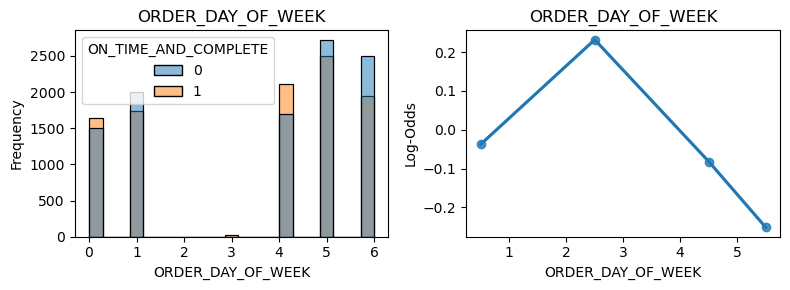

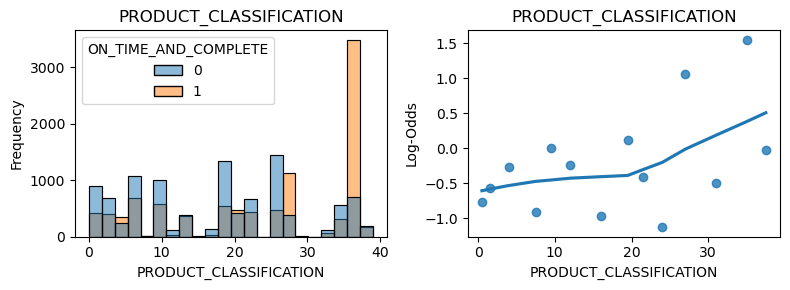

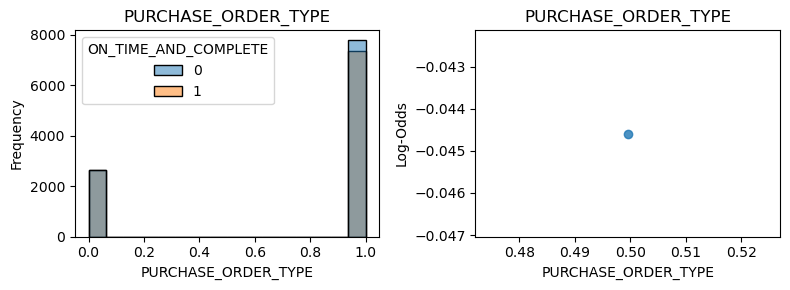

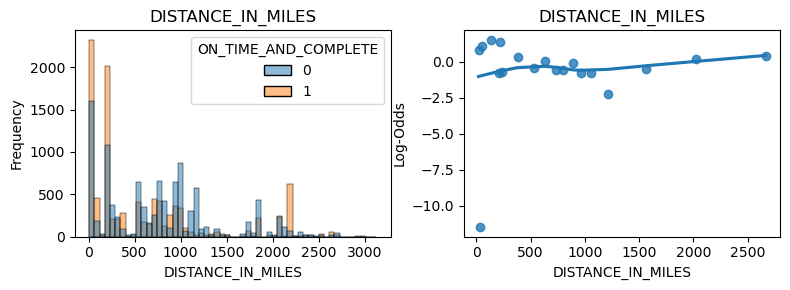

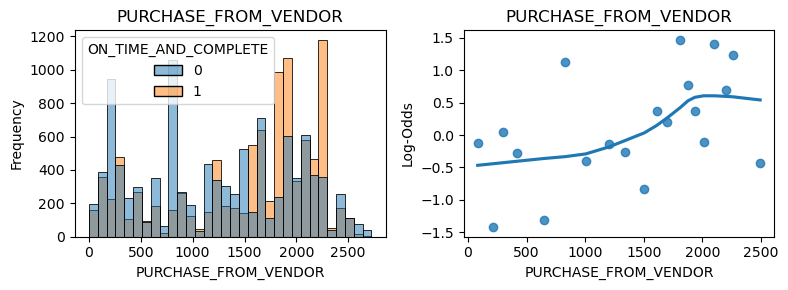

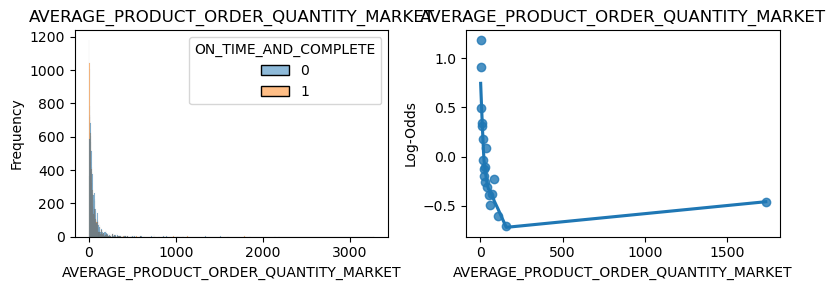

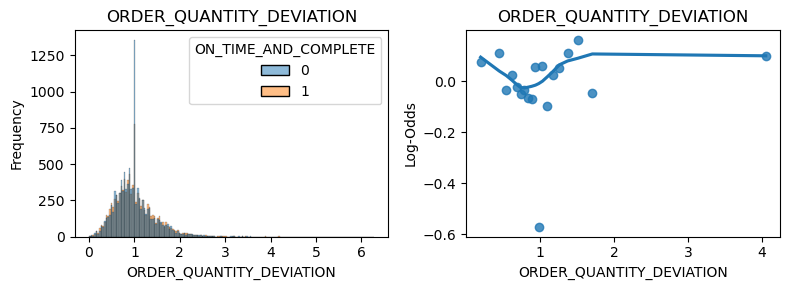

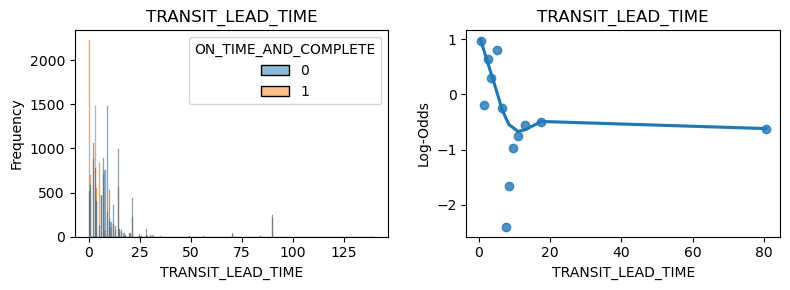

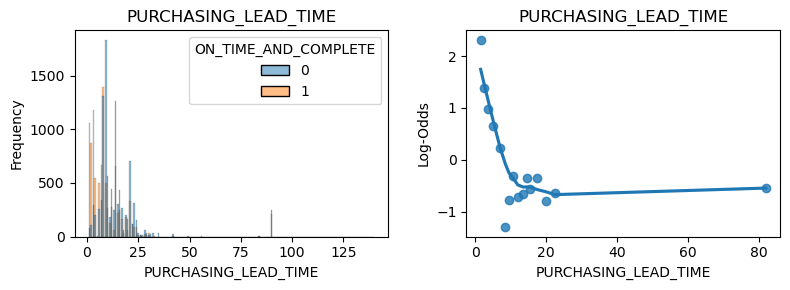

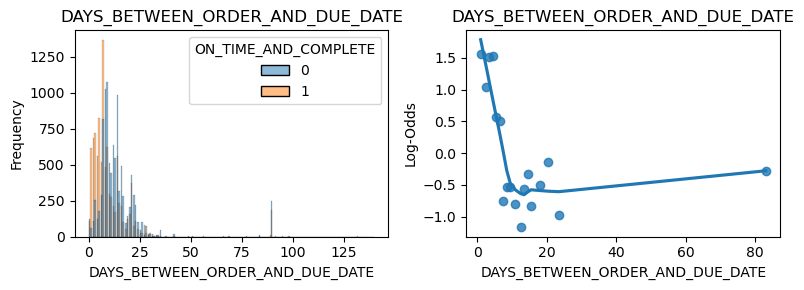

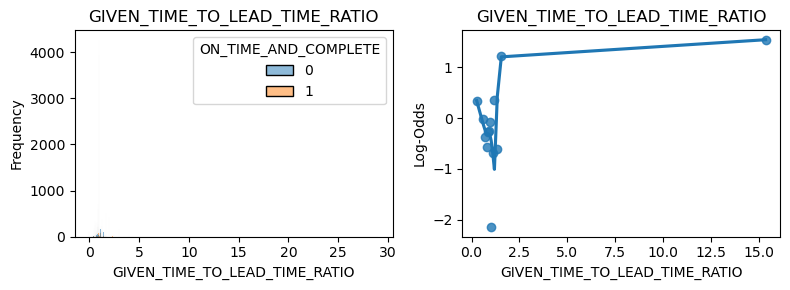

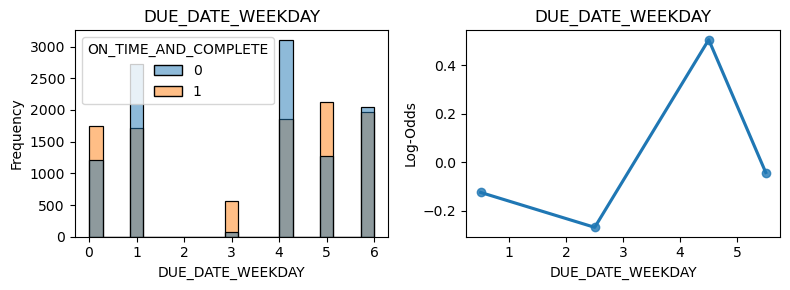

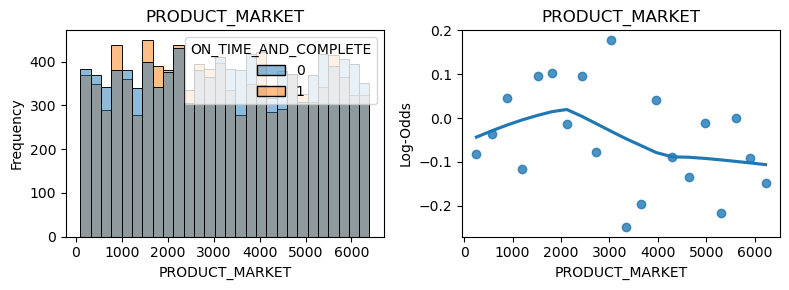

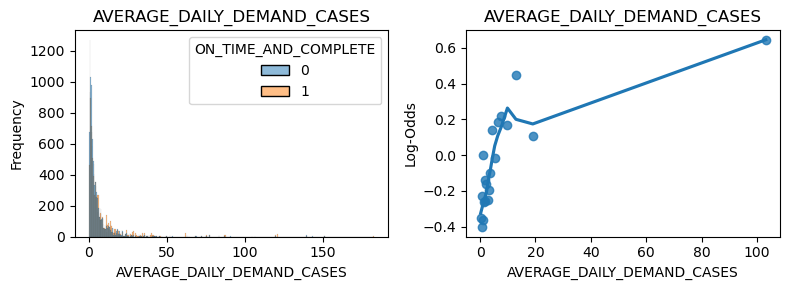

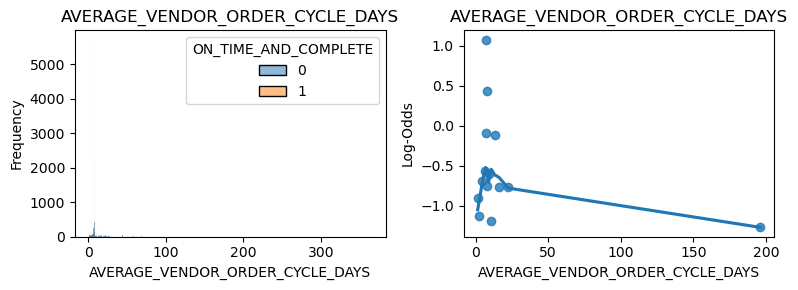

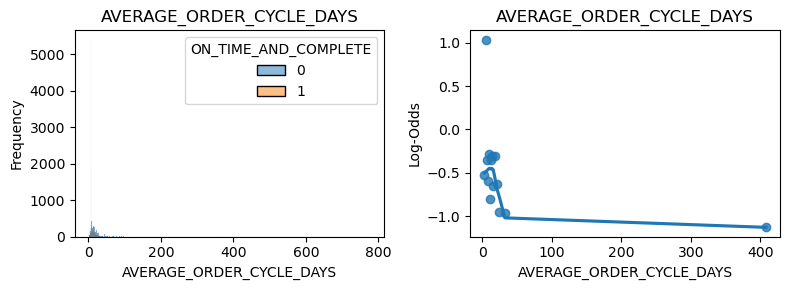

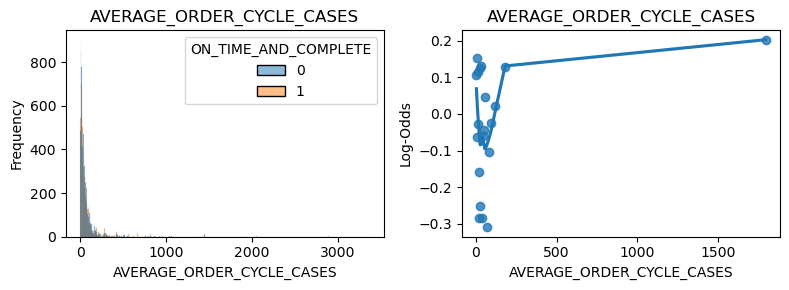

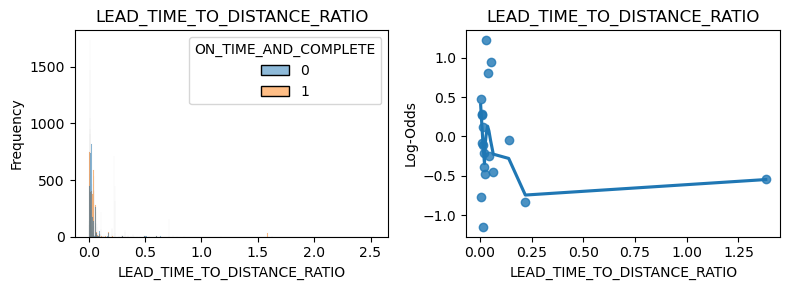

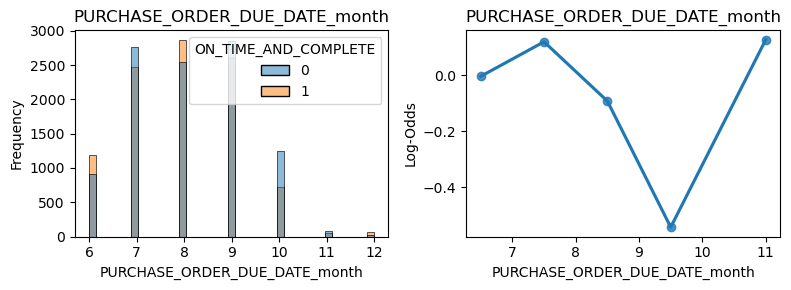

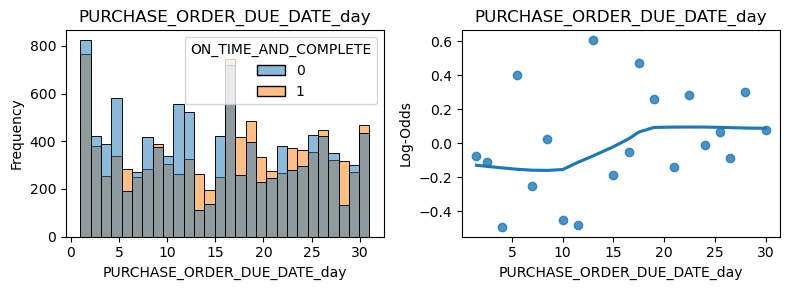

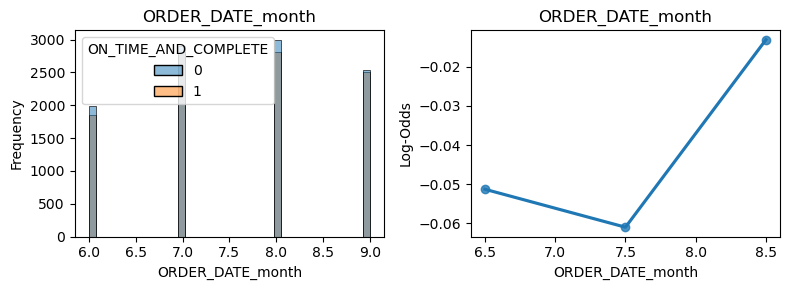

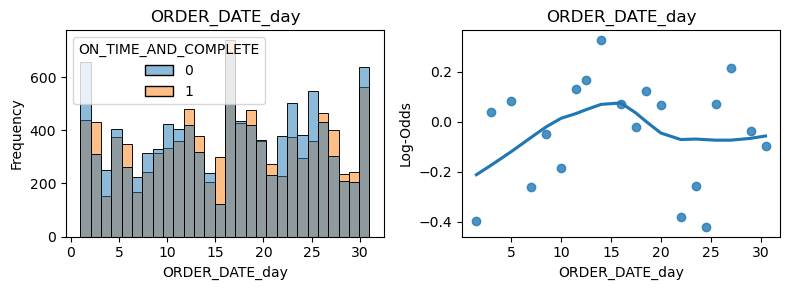

In [5]:
### ------------------- DEALING WITH DATETIME COLUMNS -------------------

### Dealing with datetime columns

# Converting columns containing dates to pd.datetime format (both train and test data)
train['PURCHASE_ORDER_DUE_DATE'] = pd.to_datetime(train['PURCHASE_ORDER_DUE_DATE'])
train['ORDER_DATE'] = pd.to_datetime(train['ORDER_DATE'])

test_X['PURCHASE_ORDER_DUE_DATE'] = pd.to_datetime(test_X['PURCHASE_ORDER_DUE_DATE'])
test_X['ORDER_DATE'] = pd.to_datetime(test_X['ORDER_DATE'])

# Extracting the month and day for these new datetime columns (both train and test data)
train['PURCHASE_ORDER_DUE_DATE_month'] = train['PURCHASE_ORDER_DUE_DATE'].dt.month
train['PURCHASE_ORDER_DUE_DATE_day'] = train['PURCHASE_ORDER_DUE_DATE'].dt.day
train['ORDER_DATE_month'] = train['ORDER_DATE'].dt.month
train['ORDER_DATE_day'] = train['ORDER_DATE'].dt.day

test_X['PURCHASE_ORDER_DUE_DATE_month'] = test_X['PURCHASE_ORDER_DUE_DATE'].dt.month
test_X['PURCHASE_ORDER_DUE_DATE_day'] = test_X['PURCHASE_ORDER_DUE_DATE'].dt.day
test_X['ORDER_DATE_month'] = test_X['ORDER_DATE'].dt.month
test_X['ORDER_DATE_day'] = test_X['ORDER_DATE'].dt.day

# Dropping the original datetime columns (both train and test data)
train = train.drop(columns=['PURCHASE_ORDER_DUE_DATE', 'ORDER_DATE'])
test_X = test_X.drop(columns=['PURCHASE_ORDER_DUE_DATE', 'ORDER_DATE'])

### ------------------- DROPPING COLUMNS THAT ONLY HAVE ONE UNIQUE VALUE -------------------

# Getting the columns with only one unique value, then dropping them
train.drop(columns=train.columns[train.nunique() == 1], inplace=True)

### ------------------ DATA VISUALIZATION ON REMAINING COLUMNS-------------------

# defining the numerical columns in the dataset
num_preds = train.select_dtypes(include='number').drop(columns='ON_TIME_AND_COMPLETE').columns

# Function to approximate the log odds
def compute_log_odds(df, predictor, response, bins=20):
    df['bin'] = pd.qcut(df[predictor], q=bins, duplicates='drop') # Binning the data to get a better approximation of the relationship
    grouped = df.groupby('bin')[response].agg(['mean'])
    
    # Avoid division by zero by replacing probabilities of 0 or 1 with either 0.00001 or 0.99999
    small_number = 1e-5
    grouped['mean'] = np.clip(grouped['mean'], small_number, 1 - small_number)

    # Compute log odds
    grouped['log_odds'] = np.log(grouped['mean'] / (1 - grouped['mean']))
    
    return grouped

# For each column, plotting the distribution and the log odds aproximated relationship
train_copy = train.copy()
for col in num_preds:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Histogram of predictor on train data
    sns.histplot(data = train.copy(), x=col, ax=axes[0], hue='ON_TIME_AND_COMPLETE')
    axes[0].set_title(f'{col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    # Computing log odds for the column
    log_odds_data = compute_log_odds(train.copy(), col, 'ON_TIME_AND_COMPLETE')

    # Scatterplot with trendline (regplot) of predictor on train predictor
    sns.regplot(x = log_odds_data.index.categories.mid, y = log_odds_data['log_odds'], ax=axes[1], scatter=True, lowess=True) # lowess=True allows for a non-linear trendline to be shown
    axes[1].set_title(f'{col}')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Log-Odds')    

    # Showing the plots
    plt.tight_layout()
    plt.show()

The above plots gave me the most crucial information as to how to construct my model. 

In particular, I noticed that some variables seemed to have little-to-no relationship with the predictor variable. I was able to discern this through the scatterplots, many of which showed no relationship between the log-odds and the predictor. These variables included: `AVERAGE_VENDOR_ORDER_CYCLE_DAYS`, `AVERAGE_ORDER_CYCLE_CASES`, `SHIP_FROM_VENDOR`, `ORDER_DATE_day`, and `PURCHASE_ORDER_DUE_DATE_day`. Additionally, I saw that although `PRODUCT_NUMBER` may seem like it would need to be one-hot-encoded as a categorical variable because it represents a category of product, encoding this variable categorically would require adding over 4000 new parameters (as it has over 4000 unique values), which ended up causing overfitting. 

On the other hand, I recognized that two variables, `RESERVABLE_INDICATOR` and `PRODUCT_STATUS`, each only held one unique value, and thus were of no use to the models, so they were dropped. 

Also, I saw that some variables that were numeric in the dataset, but would likely work better as categorical variables, due to their limited number of values, or the definition of the column itself (which is given on the Kaggle competition website). These columns included: `DIVISION_NUMBER`, `ORDER_DAY_OF_WEEK`, `PURCHASE_ORDER_TYPE`, `DIVISION_CODE`, `DUE_DATE_WEEKDAY`, `PRODUCT_CLASSIFICATION`, `COMPANY_VENDOR_NUMBER`, and `PURCHASE_FROM_VENDOR`.

These graphs additionally indicated that some variables were in need of transformations in order to create a more normal-like distribution or a more linear relationship with the log odds. In particular, the predictors I recognized that would likely need a log transformation were: `AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET`,  `TRANSIT_LEAD_TIME`, `PURCHASING_LEAD_TIME`, and `DAYS_BETWEEN_ORDER_AND_DUE_DATE`. 

Finally, I recognized that some of these variables contained missing values, as well as outliers, which will be dealt with in the following section. 

## 2) Data Preprocessing

I began the data preprocessing phase by dropping the above listed columns, as well as transforming the above listed variables as specified. I noticed that one hot encoding `COMPANY_VENDOR_NUMBER` had a particularly positive effect on the model, significantly increasing its accuracy. 

The month variables that I had extracted from the datetime columns previously were also dropped, as they proved to be problematic - the training and test sets seemed to contain very different sets of unique values for the months columns. 

To deal with missing values, I first detected the columns with missingness issues - `AVERAGE_DAILY_DEMAND_CASES`, `AVERAGE_VENDOR_ORDER_CYCLE_DAYS`, `AVERAGE_ORDER_CYCLE_DAYS`, and `AVERAGE_ORDER_CYCLE_CASES`. I decided that the best way to impute these missing values was via linear regression, using each variable's top 5 most correlated variables as predictors for the missing values. 

To deal with outliers, I created the `OutlierHandler` class, which inherited the classes `BaseEstimator` and `TransformerMixin`, so as to easily integrate the custom class into my data pipeline later on. This custom class class uses IQR critera to determine datapoints that are outliers, and includes 3 strategies to impute outliers - median, mean, and clipping. To ensure that there was no data leakage while implementing this class, I made sure to learn the upper and lower IQR bounds for each column in the `fit` function, and then apply the specified outlier handling strategy to each column in the `transform` function. Doing this ensures that the class does not fit onto the test data, which would cause problems for the model. 

Below is all of the code for my data preprocessing steps. 

In [6]:
### -------------------- DROPPING VARIABLES --------------------

# Dropping variables that won't be useful
cols_to_drop = [
    'PRODUCT_NUMBER',
    'AVERAGE_VENDOR_ORDER_CYCLE_DAYS',
    'AVERAGE_ORDER_CYCLE_CASES',
    'SHIP_FROM_VENDOR',
    'ORDER_DATE_month',
    'PURCHASE_ORDER_DUE_DATE_month',
    'ORDER_DATE_day',
    'PURCHASE_ORDER_DUE_DATE_day',
]

train.drop(columns = cols_to_drop, inplace=True)
test_X.drop(columns = cols_to_drop, inplace=True)


# Redefining numerical and categorical columns
cat_preds = [
    'DIVISION_NUMBER',
    'ORDER_DAY_OF_WEEK',
    'PURCHASE_ORDER_TYPE',
    'DIVISION_CODE',
    'DUE_DATE_WEEKDAY',
    'PRODUCT_CLASSIFICATION',
    'COMPANY_VENDOR_NUMBER',
    'PURCHASE_FROM_VENDOR',
]

num_preds = [col for col in train.columns if col not in cat_preds + ["ON_TIME_AND_COMPLETE"]]


### ------------------- MISSING DATA IMPUTATION -------------------
# Detecting the columns with missing values
columns_missingness = train.isna().sum()[train.isna().sum() != 0].index
corr_matrix = train[num_preds].corr().abs() # correlation matrix to find the best variables to use as predictors in the linear regressions below
# For the columns with missing values, finding which five columns have the best correlation with it, and building a linear regression to impute the missing values based on those predictor variables
for col in columns_missingness:
    vars_with_highest_corr = list(corr_matrix[col].drop(columns_missingness).sort_values(ascending=False).index[0:5]) # getting the five variables with the highest correlation as X in the LR
    # Building a linear regression to impute col using var_with_highest_corr
    x = train[vars_with_highest_corr]
    y = train[col]
    idx_non_missing = np.isfinite(x).all(axis=1) & np.isfinite(y)
    model = LinearRegression()
    model.fit(x[idx_non_missing], y[idx_non_missing])

    # Imputing the train data
    missing_idx_train = train[col].isna()
    train.loc[missing_idx_train, col] = model.predict(train.loc[missing_idx_train, vars_with_highest_corr])

    # Imputing the test data
    missing_idx_test = test_X[col].isna()
    test_X.loc[missing_idx_test, col] = model.predict(test_X.loc[missing_idx_test, vars_with_highest_corr])


### -------------------- CUSTOM CLASSES FOR PIPELINES --------------------

class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, target_column=None, iqr_multiplier=1.5, strategy='clip'):

        ### Defining the self attributes

        self.columns = columns
        self.target_column = target_column
        self.iqr_multiplier = iqr_multiplier
        self.strategy = strategy
        self.bounds_ = {} # will store iqr bounds for each numerical column

    def fit(self, X, y=None):

        ### This column will find the upper and lower bound for each of the predictors

        X = pd.DataFrame(X)

        # Exclude the response variable from feature selection
        if self.target_column and self.target_column in X.columns:
            X_features = X.drop(columns=[self.target_column])
        else:
            X_features = X

        # Use all numerical columns
        if self.columns is None:
            self.columns = X_features.select_dtypes(include='number').columns.tolist()

        self.bounds_ = {}
        for col in self.columns:
            Q1 = X_features[col].quantile(0.25)
            Q3 = X_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.iqr_multiplier * IQR
            upper_bound = Q3 + self.iqr_multiplier * IQR
            self.bounds_[col] = (lower_bound, upper_bound)

        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()

        # Apply outlier handling, for each of the three strategies
        for col in self.columns:
            lower_bound, upper_bound = self.bounds_[col]

            # Median imputation strategy
            if self.strategy == 'median':
                median_value = X[col].median()
                X[col] = np.where((X[col] < lower_bound) | (X[col] > upper_bound), median_value, X[col])

            # Mean imputation strategy
            elif self.strategy == 'mean':
                mean_value = X[col].mean()
                X[col] = np.where((X[col] < lower_bound) | (X[col] > upper_bound), mean_value, X[col])

            # Clipping imputation strategy
            elif self.strategy == 'clip':
                X[col] = X[col].clip(lower=lower_bound, upper=upper_bound)

        return X


### ------------------ TRANSFORMATIONS -------------------

# Log transformations
log_preds = [
    'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET', 
    'TRANSIT_LEAD_TIME',
    'PURCHASING_LEAD_TIME', # INCREASES ACCURACY
    'DAYS_BETWEEN_ORDER_AND_DUE_DATE', # INCREASES ACCURACY
    
]

def log_transformation(X):
    X = np.where(X <= -1, 0.999, X) # making sure to not pass negative values to the logorithm
    return np.log1p(X)

for col in log_preds:
    train[col] = log_transformation(train[col])
    test_X[col] = log_transformation(test_X[col])


# Making new categorical columns
train['AVERAGE_ORDER_CYCLE_DAYS_binned'] = pd.cut(train['AVERAGE_ORDER_CYCLE_DAYS'], bins=[-1,6,8,20])
test_X['AVERAGE_ORDER_CYCLE_DAYS_binned'] = pd.cut(test_X['AVERAGE_ORDER_CYCLE_DAYS'], bins=[-1,6,8,20])

cat_preds = cat_preds + [
    'AVERAGE_ORDER_CYCLE_DAYS_binned', 
]

train.drop(columns=['AVERAGE_ORDER_CYCLE_DAYS'], inplace=True) # dropping original columns from train
test_X.drop(columns=['AVERAGE_ORDER_CYCLE_DAYS'], inplace=True) # and from test

# Redefining the numerical columns to include those just created
num_preds = [col for col in train.columns if col not in cat_preds + ["ON_TIME_AND_COMPLETE"]]

## 3) Feature Engineering

I created only one new feature, which is included in the above code - `AVERAGE_ORDER_CYCLE_DAYS_binned`. This variable is a binned version of the `AVERAGE_ORDER_CYCLE_DAYS` column. After imputing its outliers and reinspecting its histogram and log-odds plot, I determined that it had ranges of values for which it was extremely likely to take on the value of 1 (in the response), and other ranges for which it was extremely likely to take on the value of 0. Rather than using a numerical transformation, I found it much more helpful to the model's accuracy to bin it around the values which separated the ranges of values in which it took on distinct values of the response. Thus, I included this new binned predictor as a categorical variable in the model. 

Additionally, I made log transformations to various columns, which are listed in the above section, and dropped other columns I found to be not useful (also listed in the above section).



## 4) Model Selection and Training

I decided to use a sklearn `Pipeline` and `ColumnTransformer` to create my model's pipeline, which can be seen in the below section. In this pipeline, I apply my `OutlierHandler` class to the numerical variables, and then scale them using `StandardScaler`. I also one hot encode the categorical variables to ready them for the model using `OneHotEncoder` from sklearn. 

Below is the code creating the model. 

In [7]:
### ------------------- PIPELINE -------------------

# Numerical pipeline
num_pipeline = Pipeline([
    ('outlier_handler', OutlierHandler(strategy='clip')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combining the numerical and categorical pipelines into a preprocessor ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_preds),
    ('cat', cat_pipeline, cat_preds)
])

# Combining the preprocessor with the model to make the finalized pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=5000, solver='lbfgs'))
])

## ------------------- FITTING THE MODEL (FULL DATASET) -------------------

# Fitting the model
model_full = pipeline.fit(train.drop(columns=['ON_TIME_AND_COMPLETE']), train['ON_TIME_AND_COMPLETE'])
model_full

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outlier_handler',
                                                                   OutlierHandler()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DISTANCE_IN_MILES',
                                                   'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET',
                                                   'ORDER_QUANTITY_DEVIATION',
                                                   'TRANSIT_LEAD_TIME',
                                                   'PURCHASING_LEAD_TIME',
                                                   'DAYS_BETWEEN_ORDER_AND_DUE_DATE',
                                                   'GIVEN_TIME_TO_LEAD_TIME_RATIO'...
                                                   'LEAD_TIME_TO_DISTANCE_RATIO']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['DIVISION_NUMBER',
                                                   'ORDER_DAY_OF_WEEK',
                                                   'PURCHASE_ORDER_TYPE',
                                                   'DIVISION_CODE',
                                                   'DUE_DATE_WEEKDAY',
                                                   'PRODUCT_CLASSIFICATION',
                                                   'COMPANY_VENDOR_NUMBER',
                                                   'PURCHASE_FROM_VENDOR',
                                                   'AVERAGE_ORDER_CYCLE_DAYS_binned'])])),
                ('model', LogisticRegression(max_iter=5000))])

## 5) Model Prediction and Evaluation

In [8]:
### ------------------- MODEL EVALUATOION -------------------

train_accuracy = accuracy_score(train['ON_TIME_AND_COMPLETE'], model_full.predict(train.drop(columns=['ON_TIME_AND_COMPLETE'])))
print("Train accuracy:", train_accuracy)

Train accuracy: 0.7964532405819821


In [9]:
### ------------- MODEL PREDICTIONS & EXPORTING -------------

# Making predicitons
predicted_classes = model_full.predict(test_X)

# Exporting for a kaggle submission - a csv file with two columns: ID and ON_TIME_AND_COMPLETE
submission = pd.DataFrame({"ID": test_X['ID'], "ON_TIME_AND_COMPLETE": predicted_classes})
submission.to_csv("submission6.4.csv", index=False)

/Users/hayden/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [5, 6, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


The above submission file contains the predictions on the test set. This particular set of predictions yields a test accuracy (as given by my Kaggle public leaderboard score) of 76.186%. 

As I stated before, this test accuracy is lower than my train accuracy, which is why in the future, I will reduce this overfitting through regularization, better feature selection, cross-validation, and hyperparameter tuning. 

## 6) Complete Code Submission

* Provide a link to your Kaggle notebook or a GitHub repository containing your code.
* Ensure the notebook is properly commented and reproducible.

## 7) Reflection and Challenges

The main challenge that I encountered during this prediction problem was that my test accuracy was not improving, even when I made transformations to variables and added interaction terms. No matter what I did, for a while I seemed to be stuck at ~73% test accuracy, all while my training accuracy was at around 78%. I recognized that this was stemming from an overfitting issue, and to solve this, I decided to reduce my model's complexity and improve generalizability by removing many of the unnecessary variables that were not helping my model distinguish between the classes. I also identified a number of variables that, although initially seeming to be numerical/continuous due to their datatype (int or float), actually helped the model better as categorical variables. I identified and solved this problem this primarily through EDA and creating visualizations. 

There are many improvements that I would like to make to my model, namely further reducing the model's overfitting and obtaining better evaluation metrics. There is still a somewhat significant gap between my training accuracy and my test accuracy, which ideally would be closer together. In order to better generalize my model to the unseen test data, I plan on implementing regularization, cross validation, and hyperparameter tuning. This will help my model become more generalizable, and reduce the current gap between my train and test accuracies. 

Additionally, to potentially improve my model's accuracy, I will plot accuracy vs the decision threshold to find the most optimal decision threshold, maximizing accuracy. Thus far, I have only been using a threshold of 0.5, which can definitely be improved upon. I will potentially include this in my hyperparameter tuning grid search in the future. 